# Exploring & Processing Data

In this jupyter notebook we will explore the datasets used for our project. We will primarily focus on 

In [37]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from census import Census

import os

from shapely.geometry import Point, Polygon

# Loading environment variables
from dotenv import load_dotenv
load_dotenv()
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY")

## 311 Cases in 2023

Below is the raw table of all 311 service requests opened in 2023.

In [38]:
serv_req_df = pd.read_csv("data/raw/311_Cases_2023.csv")

Let's do a quick analysis of what this dataset consists of.

In [39]:
serv_req_df.sample(5)

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,...,Police District,Latitude,Longitude,Point,point_geom,Source,Media URL,BOS_2012,data_as_of,data_loaded_at
233355,16670265,04/14/2023 08:51:00 AM,04/15/2023 07:24:46 AM,04/15/2023 07:24:46 AM,Closed,Case Resolved - Pickup completed.,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,...,TENDERLOIN,37.785735,-122.414395,"(37.7857353, -122.4143947)",POINT (-122.414394704 37.785735295),Web,NaN,6.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
634778,17390724,10/06/2023 02:02:15 PM,10/14/2023 01:36:05 PM,10/14/2023 01:36:05 PM,Closed,Case Resolved,DPW Ops Queue,Illegal Postings,Illegal Postings - Affixed_Improperly,Affixed Improperly,...,PARK,37.764195,-122.463058,"(37.764195, -122.46305833)",POINT (-122.463058333 37.764195),Mobile/Open311,NaN,NaN,2024/04/09 09:12:00 AM,2024/09/11 05:09:50 PM
65691,16363424,01/29/2023 01:28:00 PM,01/30/2023 08:35:14 AM,01/30/2023 08:35:14 AM,Closed,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,...,BAYVIEW,37.721652,-122.401133,"(37.721652, -122.4011325)",POINT (-122.4011325 37.721652),Web,NaN,9.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM
718658,17546440,11/13/2023 12:32:19 PM,11/13/2023 01:33:34 PM,11/13/2023 01:33:34 PM,Closed,Case Resolved,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,...,NORTHERN,37.786062,-122.432974,"(37.78606228, -122.43297385)",POINT (-122.432973851 37.786062279),Mobile/Open311,NaN,NaN,2024/04/10 10:23:00 AM,2024/09/11 05:09:50 PM
138829,16499098,03/03/2023 12:38:00 PM,04/03/2023 12:38:03 PM,04/03/2023 12:38:03 PM,Closed,Case Resolved - Tree will be prunedduring the ...,DPW Ops Queue,Tree Maintenance,Trees - Overgrown_Tree,Pruning_request,...,MISSION,37.757090,-122.439056,"(37.7570905, -122.4390564)",POINT (-122.4390564 37.7570905),Web,NaN,8.0,2024/02/20 10:35:55 AM,2024/09/11 05:09:50 PM


In [40]:
print("Current columns in the dataset and their datatypes:\n",\
    serv_req_df.dtypes)

Current columns in the dataset and their datatypes:
 CaseID                     int64
Opened                    object
Closed                    object
Updated                   object
Status                    object
Status Notes              object
Responsible Agency        object
Category                  object
Request Type              object
Request Details           object
Address                   object
Street                    object
Supervisor District      float64
Neighborhood              object
Analysis Neighborhood     object
Police District           object
Latitude                 float64
Longitude                float64
Point                     object
point_geom                object
Source                    object
Media URL                 object
BOS_2012                 float64
data_as_of                object
data_loaded_at            object
dtype: object


## Cleaning the Service Requests DataFrame

### Initial Cleanup

In [41]:
# Selecting useful columns
useful_cols = [
    'CaseID', 'Opened', 'Closed', 'Updated', 'Status', 'Status Notes',
    'Responsible Agency', 'Category', 'Request Type', 'Request Details',
    'Neighborhood', 'Analysis Neighborhood', 'Police District',
    'Latitude', 'Longitude', 'Source'
]

serv_req_df = serv_req_df[useful_cols].copy()

# Removing duplicates and filtering by SF bounding box
serv_req_df.drop_duplicates(subset='CaseID', inplace=True)
serv_req_df = serv_req_df[
    serv_req_df['Latitude'].between(37.6, 37.9) &
    serv_req_df['Longitude'].between(-123.2, -122.3)
]

# Simplifying column names
serv_req_df.columns = (
    serv_req_df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

print("DataFrame snippet so far:\n")
display(serv_req_df.sample(3))

DataFrame snippet so far:



,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,neighborhood,analysis_neighborhood,police_district,latitude,longitude,source
786528,17677338,12/19/2023 08:07:00 AM,12/22/2023 12:00:00 AM,12/22/2023 12:00:00 AM,Closed,Case Resolved - 12/22/23: A-Frame has been rem...,DPW BSM Queue,General Request - PUBLIC WORKS,request_for_service,bsm - request_for_service,Golden Gate Heights,Inner Sunset,TARAVAL,37.757686,-122.466006,Phone
94590,16416582,02/10/2023 10:06:32 PM,02/10/2023 10:07:13 PM,02/10/2023 10:07:13 PM,Closed,Case is Invalid - Contact name and phone numbe...,Parking Enforcement Review Queue,Parking Enforcement,Blocking_Driveway_Cite_Only,txtColor - txtModel - 8CQM660,Outer Sunset,Sunset/Parkside,TARAVAL,37.765067,-122.479158,Web
119478,16461893,02/22/2023 02:16:43 PM,02/24/2023 05:23:00 AM,02/24/2023 05:23:00 AM,Closed,Case Resolved,DPW Ops Queue,Litter Receptacles,Other_garbage_can_repair,NaN,Financial District,Financial District/South Beach,CENTRAL,37.794356,-122.398898,Web


### Categorizing Categoricals

We're just marking a column if they're a categorical or not.

In [42]:
cat_cols = [
    'status',
    'status_notes',
    'responsible_agency',
    'category',
    'request_type',
    'request_details',
    'neighborhood',
    'analysis_neighborhood',
    'police_district',
    'source'
]

for col in cat_cols:
    if col in serv_req_df.columns:
        serv_req_df[col] = (
            serv_req_df[col]
            .astype('string')                      # efficient string dtype
            .str.strip()                           # remove leading/trailing spaces
            .str.replace(r'\s+', ' ', regex=True)  # collapse multiple spaces
            .str.replace('_', ' ', regex=False)    # underscores → spaces
            .str.title()                           # nice display casing
        )

### Temporal Cleanup

In [43]:
# Properly format date columns
date_cols = ['opened', 'closed', 'updated']
for col in date_cols:
    serv_req_df[col] = pd.to_datetime(
        serv_req_df[col],
        format='%m/%d/%Y %I:%M:%S %p',
        errors='coerce'
    )
    
# Deriving new temporal columns
serv_req_df['year'] = serv_req_df['opened'].dt.year.astype('Int16')
serv_req_df['month'] = serv_req_df['opened'].dt.month.astype('Int8')
serv_req_df['dow'] = serv_req_df['opened'].dt.day_name()
serv_req_df['hour'] = serv_req_df['opened'].dt.hour.astype('Int8')
serv_req_df['request_duration_hrs'] = (
    (serv_req_df['closed'] - serv_req_df['opened'])
    .dt.total_seconds() / 3600
)

### Spatial Cleanup

In [44]:
serv_req_gdf = gpd.GeoDataFrame(
    serv_req_df,
    geometry=gpd.points_from_xy(serv_req_df.longitude, serv_req_df.latitude),
    crs='EPSG:4326'
)

### Some final touches

Some final touches to make sure each column is the right data type.

In [45]:
serv_req_gdf['neighborhood'] = (
    serv_req_gdf['analysis_neighborhood']
    .fillna(serv_req_gdf['neighborhood'])
    .str.strip()
    .str.title()
)
serv_req_gdf.drop(columns=['analysis_neighborhood'], inplace=True)

serv_req_gdf['category_clean'] = serv_req_gdf['category'].str.title().str.strip()
serv_req_gdf['agency_clean'] = serv_req_gdf['responsible_agency'].str.replace('_', ' ').str.title()

serv_req_gdf['is_closed'] = serv_req_gdf['status'].eq('Closed').astype('bool')

bins = [0, 1, 24, 72, np.inf]
labels = ['<1hr', '1–24hr', '1–3days', '>3days']
serv_req_gdf['response_time_cat'] = pd.cut(
    serv_req_gdf['request_duration_hrs'], bins=bins, labels=labels
)

# A preview of the cleaned GeoDataFrame
display(serv_req_gdf.sample(3))
print("Updated column data types:\n", \
    serv_req_gdf.dtypes)

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,year,month,dow,hour,request_duration_hrs,geometry,category_clean,agency_clean,is_closed,response_time_cat
17943,16276166,2023-01-09 11:00:00,2023-01-09 17:25:12,2023-01-09 17:25:12,Closed,Case Resolved - Pickup Completed.,Recology Abandoned,Street And Sidewalk Cleaning,Bulky Items,Boxed Or Bagged Items,...,2023,1,Monday,11,6.420000,POINT (-122.4087 37.79771),Street And Sidewalk Cleaning,Recology Abandoned,True,1–24hr
365912,16914472,2023-06-14 12:09:00,2023-06-16 12:02:00,2023-06-16 12:02:00,Closed,Case Resolved,Dpw Ops Queue,Street And Sidewalk Cleaning,Hazardous Materials,Glass,...,2023,6,Wednesday,12,47.883333,POINT (-122.44829 37.74239),Street And Sidewalk Cleaning,Dpw Ops Queue,True,1–3days
660777,17437781,2023-10-18 09:19:00,2023-10-18 11:30:20,2023-10-18 11:30:20,Closed,Case Resolved - Pickup Completed.,Recology Abandoned,Street And Sidewalk Cleaning,Bulky Items,Boxed Or Bagged Items,...,2023,10,Wednesday,9,2.188889,POINT (-122.41627 37.79315),Street And Sidewalk Cleaning,Recology Abandoned,True,1–24hr


Updated column data types:
 caseid                           int64
opened                  datetime64[ns]
closed                  datetime64[ns]
updated                 datetime64[ns]
status                  string[python]
status_notes            string[python]
responsible_agency      string[python]
category                string[python]
request_type            string[python]
request_details         string[python]
neighborhood            string[python]
police_district         string[python]
latitude                       float64
longitude                      float64
source                  string[python]
year                             Int16
month                             Int8
dow                             object
hour                              Int8
request_duration_hrs           float64
geometry                      geometry
category_clean          string[python]
agency_clean            string[python]
is_closed                         bool
response_time_cat             catego

### Simple Plot

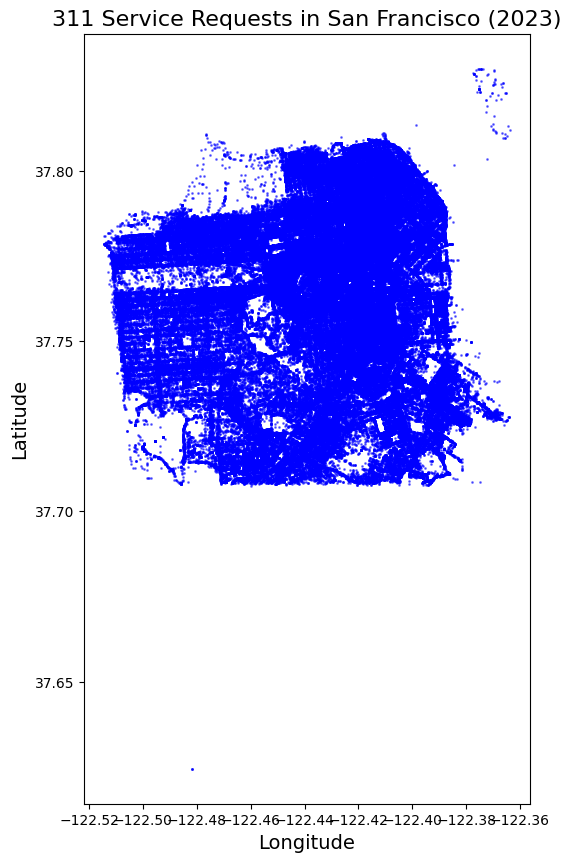

In [ ]:
# Plot a simple visualization of the points
fig, ax = plt.subplots(figsize=(10, 10))
serv_req_gdf.plot(ax=ax, markersize=1, color='blue', alpha=0.5)
ax.set_title("311 Service Requests in San Francisco (2023)", fontsize=16)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
plt.show()


### Caching DataFrame

This helps having to re-run the notebook the cleaning on each notebook boot.

In [ ]:
serv_req_gdf.to_parquet('data/processed/serv_req_cleaned.parquet', index=False)

## Census ACS Data